# Imports and preamble

In [1]:
# !pip install pulp
# !apt-get install glpk-utils
# !apt-get install coinor-cbc

    100% |████████████████████████████████| 39.2MB 1.1MB/s 
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [1]:
import numpy as np
import pulp

## Kestrel solver

In [2]:
import time
import xmlrpc.client
import sys
import os
import lxml.etree
import lxml.builder 
from pulp.solvers import LpSolver_CMD
from pulp.solvers import PulpSolverError
from pulp.constants import *

In [3]:
class Kestrel(LpSolver_CMD):
    """
    API Wrapper for Neos Solver XML-RPC API. Compatible with pulp linear programming api.
    Only Xpress solver works; in the future more solvers will be added
    :param ptype: problem type for example 'milp': mixed integer linear programming
    olny tested with 'milp', 'lp'
    :param maximize: 'yes' or 'no' to maximize or minimize respectibly
    :param email: add your email
    :param priority: default 'long', if 'short' is scpecified job will be killed after 5 min
    :param  keepFiles = 0, mip = 1, msg = 0, options = []: neccesary to make LpSolver_CMD  work
    """
    def __init__(self, ptype, maximize=None, email=None, priority=None, keepFiles=0, mip=1, msg=0, options=[]):
        self.ptype = ptype
        if maximize:
            self.maximize = 'yes'
        else:
            self.maximize = "no"
        if email:
            self.email=email
        else:
            raise ValueError('Missing email')
        if priority:
            self.priority = priority
        else:
            self.priority = 'long'
        LpSolver_CMD.__init__(self, './', keepFiles, mip, msg, options)

    def copy(self):
        """Make a copy of self"""
        aCopy = LpSolver_CMD.copy(self)
        aCopy.cuts = self.cuts
        aCopy.presolve = self.presolve
        aCopy.dual = self.dual
        aCopy.strong = self.strong
        return aCopy

    def actualSolve(self, lp, **kwargs):
        """Solve a well formulated lp problem"""
        return self.solve_Kestrel(lp, **kwargs)

    def available(self):
        """True if the solver is available"""
        neos = xmlrpc.client.ServerProxy("https://neos-server.org:3333")
        alive = neos.ping()
        if alive!="NeosServer is alive\n":
            print("Could not make connection to NEOS Server")
            available = False
        else:
            available = True
        return available

    def solve_Kestrel(self, lp):
        vs = lp.writeMPS("problem.mps", rename = 0)
        file = open('problem.mps', "r")
        E = lxml.builder.ElementMaker()
        root = E.document
        field1 = E.category
        field2 = E.solver
        field3 = E.inputMethod
        field4 = E.MPS
        field5 = E.maximize
        field6 = E.nosol
        field7 = E.email
        field8 = E.priority
        xmldoc = root(
                     field1(self.ptype),
                     field2("FICO-Xpress"),
                     field3("MPS"),
                     field4(lxml.etree.CDATA(file.read())),
                     field5(self.maximize),
                     field6("no"),
                     field7(self.email),
                     field8(self.priority))
        xml = lxml.etree.tostring(xmldoc).decode()
        file.close()
        try:
            os.remove('problem.mps')
        except:
            pass
        neos = xmlrpc.client.ServerProxy("https://neos-server.org:3333")
        alive = neos.ping()
        if alive != "NeosServer is alive\n":
            raise RuntimeError("Could not make connection to NEOS Server")
        else:
            (jobNumber, password) = neos.submitJob(xml)
            print("Job number = {} Job password = {}".format(jobNumber, password))
            if jobNumber == 0:
                raise RuntimeError("NEOS Server error: {}".format(password))
            else:
                status=""
                while status!="Done":
                    time.sleep(5)
                    status= neos.getJobStatus(jobNumber, password)
                    print('Solving... Problem status: ', status)
                msg=neos.getFinalResults(jobNumber, password)
                #print(msg.data.decode())
                tmpSol=open('tmpSol.txt', 'w')
                tmpSol.write(msg.data.decode())
                tmpSol.close()
        values= self.readsol_MPS(self.path+'tmpSol.txt')
        try:
            os.remove('tmpSol.txt')
        except:
            pass
        kestrelStatus = {"Done": LpStatusOptimal}
        if status not in kestrelStatus:
            raise PulpSolverError("Unknown status returned by Kestrel: " + statusString)
        lp.status = kestrelStatus[status]
        lp.assignVarsVals(values)
        return lp.status

    def readsol_MPS(self, filename):
        with open(filename,'r') as f:
            values = {}
            while 1:
                l = f.readline()
                if l == "": break
                line = l.split()
                if len(line) and line[0] == 'C':
                    name = line[2]
                    value = float(line[4])
                    values[name] = value
        return values

# Job shop Scheduling
Scheduling es la asignación de recursos a lo largo del tiempo. En los Job shop mal programados, no es nada raro que los trabajos esperen durante el 95 por ciento de su ciclo de producción total. Esto resulta en un largo ciclo de flujo de trabajo. Si a esto le sumamos el tiempo de inventario y el tiempo de cobro de cuentas por cobrar, se obtendrá un largo ciclo de flujo de caja. Por lo tanto, el flujo de trabajo es igual al flujo de caja, y el flujo de trabajo es impulsado por el schedule. Un schedule es un calendario para realizar actividades, utilizar recursos o asignar instalaciones.

En un problema de Scheduling tenemos que realizar un conjunto de trabajos en varios procesadores que utilizan otros recursos bajo ciertas restricciones, como restricciones en los tiempos de finalización del trabajo, prioridades entre trabajos (un trabajo no puede comenzar hasta que otro está terminado), etc. El objetivo es optimizar algún criterio, por ejemplo, minimizar el tiempo total de procesamiento, que es el tiempo de finalización del último trabajo (suponiendo que el primer trabajo comienza en el tiempo $0$); o maximizar el número de trabajos procesados.

A continuación formulamos un problema de scheduling muy general que subsume como casos especiales una gran cantidad de problemas de scheduling estudiados en la literatura.

## Fomulacion del problema de Job shop scheduling
Se nos dan $n$ trabajos para ser procesados en $m$ procesadores (máquinas). Sea $M_j \subseteq \mathcal{P} = \{ 1, \cdots, m\}$ el subconjunto de procesadores que pueden cumplir con el trabajo $j \in \mathcal{J} = \{ 1, \cdots, n\}$. Cada trabajo $j$ se caracteriza por los siguientes parámetros:


*   $w_j$: peso del trabajo
*   $r_j, d_j$: fechas de liberación y vencimiento (el trabajo debe procesarse durante el intervalo de tiempo $[r_j, d_j]$
*   $p_{jk}$: tiempo de procesamiento en la maquina $k$

Las relaciones de precedencia entre puestos de trabajo están dadas por un dígrafo acíclico $G = (\mathcal{J}, E)$ definido sobre el conjunto $\mathcal{J}$: paa cada arco $(j_1, j_2) \in \mathcal{J}$, el trabajo $j_2$ no puede empezar hasta que el trabajo $j_1$ termine.

El Job shop Scheduling implica decidir cuándo iniciar cada paso de cada trabajo en su procesador. Por lo tanto, las variables de decisión de la hora de inicio están ahora indexadas tanto por el trabajo como por el procesador:
\begin{equation}
x_{jk} = \text{hora de inicio del trabajo j en el procesador k}
\end{equation}
Los pasos de los distintos trabajos que se programan en job shop deben tener lugar en la secuencia indicada. Es decir, las horas de inicio están sujetas a restricciones de precedencia.
la restriction de precedencia que el trabajo $j$ se debe completar en el procesador $k$ antes de que comience la actividad en $k'$ puede expresarse de la siguiente manera
\begin{equation}
x_{jk} + p_{jk} \leq x_{jk'} 
\end{equation}
donde $x_{jk}$ denota el tiempo de inicio del trabajo $j$ en el procesador $k$, $p_{jk}$  es el tiempo de proceso de $j$ en $k$, y $x_{jk'}$  es el tiempo de inicio del trabajo $j$ en el procesador $k'$.
Se puede modelar los conflictos introduciendo variables de decisión discretas
\begin{equation}
        y_{jj'k}=
        \begin{cases}
            1 & \text{si j está programado antes del trabajo j' en el procesador k} \\
            0 &\text{si no}
        \end{cases}
\end{equation}
Asi como las restricciones
\begin{equation}
x_{jk} + p_{jk} \leq x_{j'k} + M(1- y_{jj'k}) \\
x_{j'k} + p_{j'k} \leq x_{jk} + My_{jj'k}
\end{equation}
Una de las características intrigantes de los modelos Job shop Scheduling es la amplia variedad de funciones objetivo que pueden ser apropiadas.

Funcion objetivo |  Ecuacion
--- | -----
Maximum completion time | $\max_j \{ x_{j\hat{k}} + p_{j\hat{k}}\}$
Mean completion time | $\frac{1}{n} \sum_j x_{j\hat{k}} + p_{j\hat{k}}$
Maximum flow time | $\max_j \{ x_{j\hat{k}} + p_{j\hat{k}} - r_j\}$
Mean flow time | $\frac{1}{n} \sum_j x_{j\hat{k}} + p_{j\hat{k}} - r_j$
Maximum lateness | $\max_j \{ x_{j\hat{k}} + p_{j\hat{k}} - d_j\}$
Mean lateness | $\frac{1}{n} \sum_j x_{j\hat{k}} + p_{j\hat{k}} - d_j$
Maximum tardiness| $\max_j \{\max\{0, x_{j\hat{k}} + p_{j\hat{k}} - d_j\}\}$
Mean tardiness| $\frac{1}{n} \sum_j \{\max\{0, x_{j\hat{k}} + p_{j\hat{k}} - d_j\}$

donde $\hat{k}$ es la ultima maquina donde debe ocurrir el trabajo $j$

## Formulacion en Pulp

In [4]:
# rows = jobs
# columns = machines
procesing_times = np.array(
    [
        [29,78,9,36,49,11,62,56,44,21],
        [43,90,75,11,69,28,46,46,72,30],
        [91,85,39,74,90,10,12,89,45,33],
        [81,95,71,99,9,52,85,98,22,43],
        [14,6,22,61,26,69,21,49,72,53],
        [84,2,52,95,48,72,47,65,6,25],
        [46,37,61,13,32,21,32,89,30,55],
        [31,86,46,74,32,88,19,48,36,79],
        [76,69,76,51,85,11,40,89,26,74],
        [85,13,61,7,64,76,47,52,90,45]
    ]
)

In [5]:
# rows = jobs
# columns = machine index
order = np.array(
    [
        [0,1,2,3,4,5,6,7,8,9],
        [0,2,4,9,3,1,6,5,7,8],
        [1,0,3,2,8,5,7,6,9,4],
        [1,2,0,4,6,8,7,3,9,5],
        [2,0,1,5,3,4,8,7,9,6],
        [2,1,5,3,8,9,0,6,4,7],
        [1,0,3,2,6,5,9,8,7,4],
        [2,0,1,5,4,6,8,9,7,3],
        [0,1,3,5,2,9,6,7,4,8],
        [1,0,2,6,8,9,5,3,4,7]
    ]
)

In [6]:
def job_shop(procesing_times, order):
    n_jobs, n_maq  = procesing_times.shape

    x = {}
    for job in range(n_jobs):
        for maq in range(n_maq):
            x[(job, maq)] = pulp.LpVariable('x_{}_{}'.format(job, maq), 0, None, pulp.LpContinuous)
    y = {}
    for maq in range(n_maq):
        for job in range(n_jobs):
            for job_ in range(n_jobs):
                if job < job_:
                    y[(job, job_, maq)] = pulp.LpVariable('y_{}_{}_{}'.format(job, job_, maq), 0, 1, pulp.LpInteger)
    z = pulp.LpVariable('z', 0, None, pulp.LpContinuous)           

    prob = pulp.LpProblem("Job_shop", pulp.LpMinimize)

    # Set objective
    prob += z

    # create precedance constrains
    for job in range(n_jobs):
        for maq in range(1, n_maq):
            prob += x[(job, order[job, maq])] >= x[(job, order[job, maq-1])] + procesing_times[job ,order[job, maq-1]]

    # create conflict constrains
    for maq in range(n_maq):
        for job in range(n_jobs):
            for job_ in range(n_jobs):
                if job < job_:
                    prob += x[(job_, maq)] >= x[(job, maq)] + procesing_times[job, maq] - 9999*y[(job, job_, maq)]
                    prob += x[(job, maq)] >= x[(job_, maq)] + procesing_times[job_, maq] - 9999*(1 - y[(job, job_, maq)])

    # Objective function
    for job in range(n_jobs):
        prob += z >= x[(job, order[job, -1])] + procesing_times[job, order[job, -1]]
    return prob

# Solving
# prob = job_shop(procesing_times, order)
# prob.writeLP("job_shop.lp")
# prob.solve(Kestrel(ptype='milp', email='jefehern@espol.edu.ec'))

In [ ]:
x_sol = np.zeros((n_jobs, n_maq))
for v in prob.variables():
    if v.name != 'z':
        line = v.name.split(sep='_')
        if line[0] == 'x':
            x_sol[int(line[1]), int(line[2])] = v.varValue
    else:
        z_sol = v.varValue

In [7]:
x_sol = np.array(
   [[ 83, 138, 228, 260, 321, 422, 433, 526, 902, 951],
    [188, 480, 283, 469, 370, 644, 583, 672, 727, 439],
    [428, 309, 593, 519, 882, 677, 807, 718, 632, 849],
    [231,  43, 157, 593, 312, 920, 321, 428, 406, 806],
    [ 22,  37,   0, 112, 173,  43, 412, 271, 199, 320],
    [568, 225,  22, 374, 834, 275, 691, 907, 469, 543],
    [ 37,   0,  96,  83, 439, 189, 157, 339, 271, 210],
    [312, 394, 237, 898, 640, 552, 672, 807, 691, 727],
    [112, 227, 358, 296, 672, 347, 543, 583, 946, 469],
    [343, 296, 434, 763, 770, 687, 495, 855, 542, 642]]
)
z_sol = 972

In [8]:
import random
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

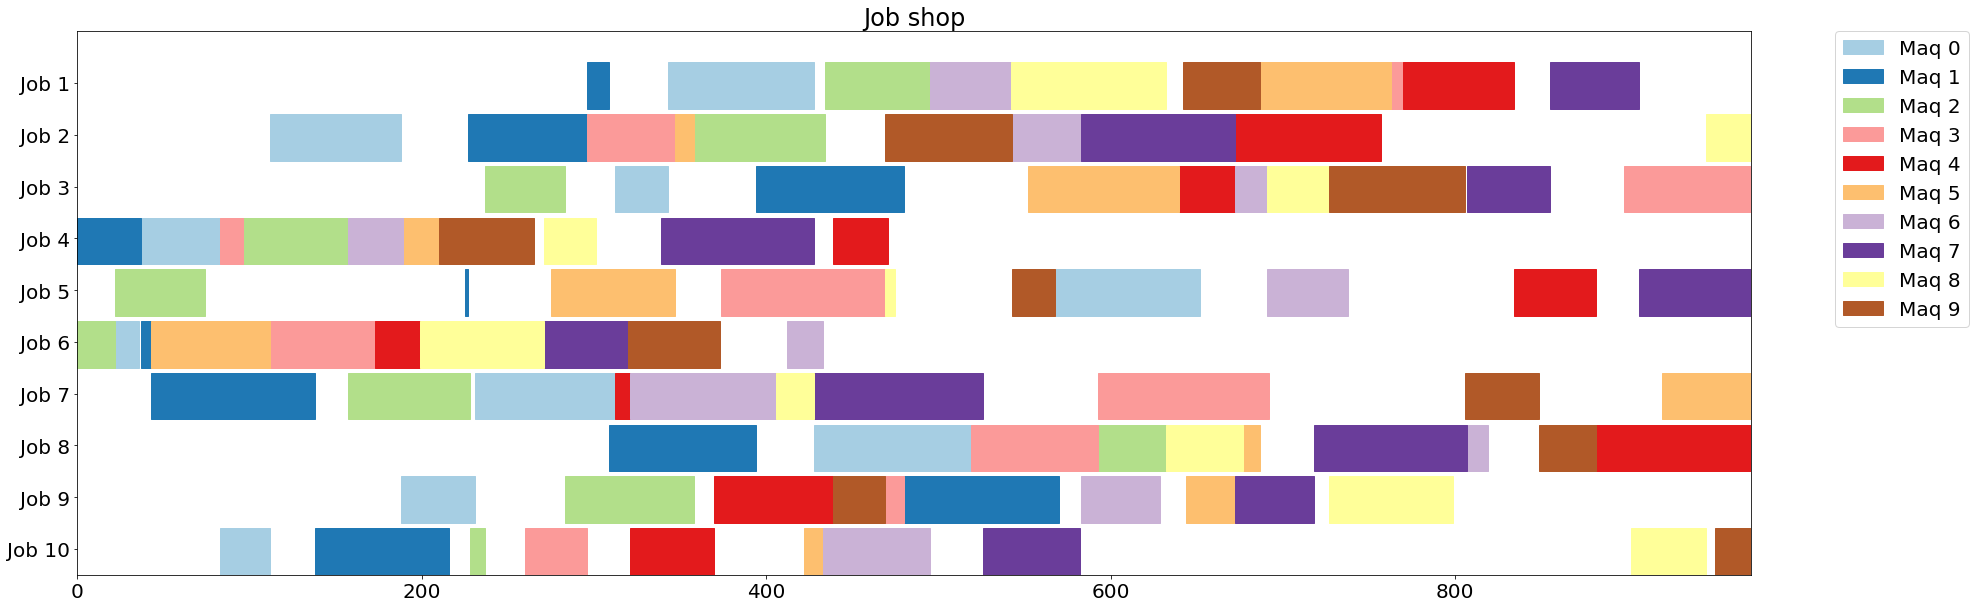

In [ ]:
plt.rcParams["font.size"] = "20"
cmap = plt.get_cmap('Paired')
colors = cmap(np.linspace(0, 1, n_maq))
fig, ax = plt.subplots(1, 1, figsize=(30,10))
ax.set_title('Job shop')
height = 0.9
for job in range(n_jobs):
    for maq in range(n_maq):
        ax.add_patch(patches.Rectangle((x_sol[job, maq], job-0.5),
                                       procesing_times[job, maq],
                                       height,
                                       color=colors[maq],
                                       alpha=1))
ax.set_ylim(-0.5, n_jobs)
ax.set_xlim(0, (x_sol + procesing_times).max())
ax.set_yticks([job for job in range(n_jobs)])
ax.set_yticklabels(['Job {}'.format(job) for job in range(n_jobs, -1, -1)])
plt.legend(handles=[mpatches.Patch(color=colors[maq], label='Maq {}'.format(maq)) for maq in range(n_maq)],
               bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Shifting bottleneck heuristic
El Shifting Bottleneck Heuristic es un procedimiento destinado a minimizar el tiempo que se tarda en hacer el trabajo, o específicamente, el makepan en un taller de trabajo. El makespan se define como la cantidad de tiempo, de principio a fin, para completar un conjunto de trabajos con varias máquinas en los que el pedido de la máquina está preestablecido para cada trabajo. Suponiendo que los puestos de trabajo compitan realmente por los mismos recursos (máquinas), siempre habrá uno o más recursos que actúen como un "cuello de botella" en el procesamiento. Este procedimiento heurístico o "regla empírica" minimiza el efecto del cuello de botella.

In [ ]:
import networkx as nx

In [ ]:
class Job(object):
    def __init__(self, Id, r, p):
        self.Id = Id
        self.r = r  # route
        self.p = p  # processing times

In [ ]:
class Jobshop(nx.DiGraph):
    def __init__(self):  # , jobs):
        super().__init__()
        self.machines = {}
        self.add_node("U", p=0)
        self.add_node("V", p=0)

    def handleJobRoutings(self, jobs):
        for j in jobs.values():
            self.add_edge("U", (j.r[0], j.Id))
            for m, n in zip(j.r[:-1], j.r[1:]):
                self.add_edge((m, j.Id), (n, j.Id))
            self.add_edge((j.r[-1], j.Id), "V")

    def handleJobProcessingTimes(self, jobs):
        for j in jobs.values():
            for m, p in zip(j.r, j.p):
                self.add_node((m, j.Id), p=p)

    def makeMachineSubgraphs(self):
        machineIds = set(ij[0] for ij in self if ij[0] not in ("U", "V"))
        for m in machineIds:
            self.machines[m] = self.subgraph(ij for ij in self if ij[0] == m)
            self.machines[m].remove_nodes_from(["U", "V"])

    def addJobs(self, jobs):
        self.handleJobRoutings(jobs)
        self.handleJobProcessingTimes(jobs)
        self.makeMachineSubgraphs()

    def output(self):
        for m in sorted(self.machines):
            for j in sorted(self.machines[m]):
                print("{}: {}".format(j, self.node[j]['C']))